In [108]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from lib.util.helper import query_table, weekday_time_series
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import plotly
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot

In [25]:
druck = weekday_time_series(sensor_id='xl106_druckmaschine_5T')

In [26]:
druck['kw'] = round(druck['kw'], 2)

In [27]:
px.line(
    x=druck.index, y=druck.kw, 
    title='UV Sigma Line',
    labels={
        'x': 'Time',
        'y': 'kW'
    },
    markers=False)

Positive skew in the variance of the time series could be a problem as GAMs assume Gaussian noise of the residuals
 - How to handle when the machine is off? (0 values)

In [28]:
stats.skew(druck.kw)

0.671627566196274

<AxesSubplot:xlabel='kw', ylabel='Count'>

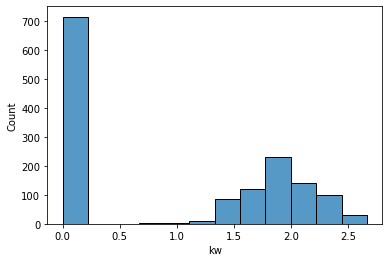

In [29]:
sns.histplot(np.log(druck.kw + 1))

In [188]:
str(druck.index.date.max())

'2021-10-15'

In [30]:
day_range = druck.index.max() - druck.index.min()
day_range

Timedelta('4 days 23:55:00')

In [31]:
druck_final = pd.DataFrame(data=druck['kw'], index=druck.index)
#druck_final['hour'] = druck_final.index.hour
druck_final.reset_index(inplace=True)

# Scaling helps with convergence via MCMC
scale = StandardScaler()
druck_final['kw'] = scale.fit_transform(druck_final['kw'].values.reshape(-1, 1))

#druck_test = druck_line[druck_line.index.day >= 17]
#druck_test_final = pd.DataFrame(data=druck_test['kw'], index=druck_test.index)

In [32]:
druck_final = druck_final.rename(columns={'t': 'ds', 'kw': 'y'})
druck_final['floor'] = -1
druck_final['cap'] = 3

In [33]:
def machine_off(ds):
    date = pd.to_datetime(ds)
    if ds.hour >= 22 or ds.hour <= 6:
        return 1
    else:
        return 0

In [34]:
#druck_final['machine_state'] = druck_final['ds'].apply(machine_off)
#druck_final['machine_state'] = ~druck_final['ds'].apply(machine_off)

In [184]:
add = {
    'name': 'hourly',
    'period': 0.041,
    'fourier_order': 30
}

add['name']

'hourly'

In [150]:
def build_prophet_model(df, future, changepoint_prior_scale=0.05, other_seasonality=None):

    m = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        growth='linear'
        #seasonality_mode='multiplicative'
    )

    #if other_seasonality is not None:
    #    assert other_seasonality != dict
    m.add_seasonality(name='hourly', period=0.041, fourier_order=30) ## higher order captures how "quickly" the seasonality can change
        #m.add_seasonality()
    #else:
    #    pass

    m.fit(df)

    forecast = m.predict(future)

    return m, forecast


In [151]:
future = pd.DataFrame(
    data=pd.date_range('2021-10-11 00:00:00', '2021-10-15 23:50:00', freq='5T'),
    columns=['ds']
    )
    
#future['machine_state'] = future['hour'].apply(lambda x: 1 if x >= 0 and x <= 6 else 0)

#future['floor'] = -1
#future['cap'] = 3

In [ ]:
model, predictions = build_prophet_model(druck_final, future, 50.0, None)

In [ ]:
predictions['yhat'] = predictions['yhat'].apply(lambda x: -0.889 if x <= 0 else x)

coef = predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
coef['actual'] = druck_final['y']
coef

In [167]:
#predictions['yhat'] = scale.inverse_transform(predictions['yhat'])

In [176]:
mape = mean_absolute_percentage_error(coef['actual'], coef['yhat'])
rmse = mean_squared_error(coef['actual'], coef['yhat'])

mape, rmse

(1.1920928766008527, 0.20708431383921544)

In [177]:
oob_upper = np.array(np.where(coef['actual'] > coef['yhat_upper']))
oob_lower = np.array(np.where(coef['actual'] < coef['yhat_lower']))

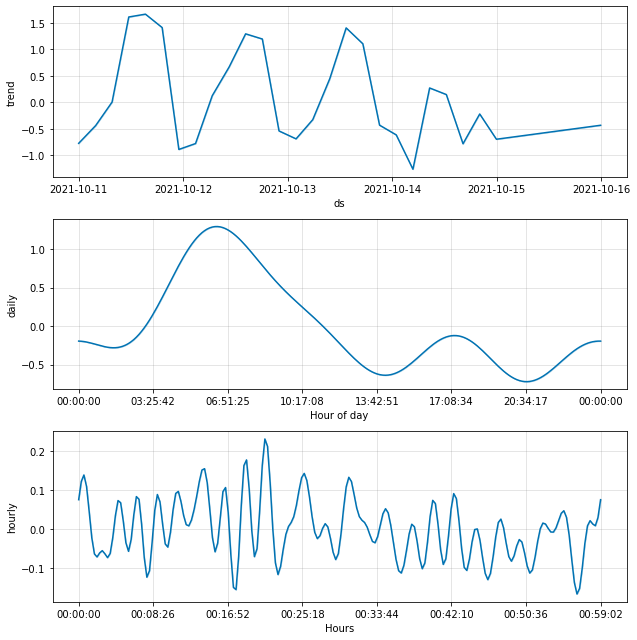

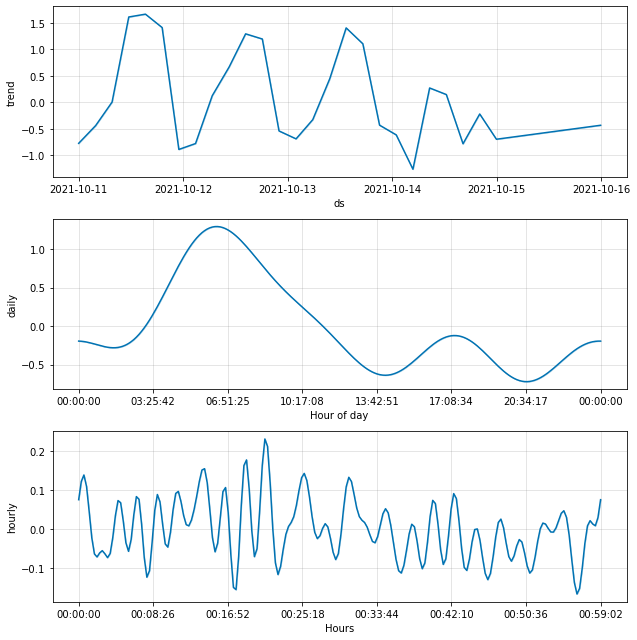

In [178]:
model.plot_components(predictions)

In [179]:
fig = plot_plotly(model, predictions)
fig.show()

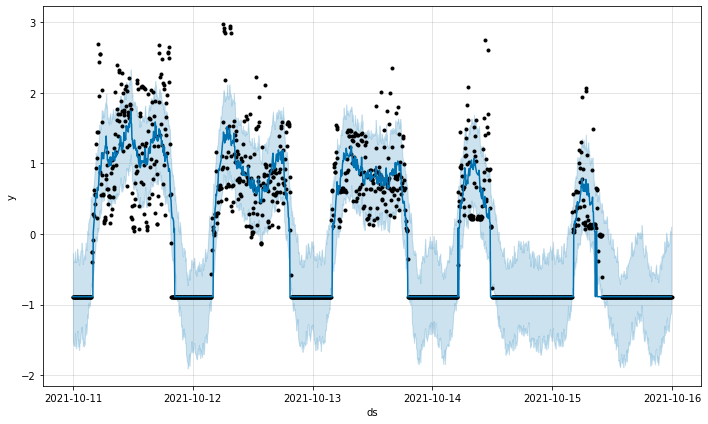

In [180]:
fig = model.plot(predictions)

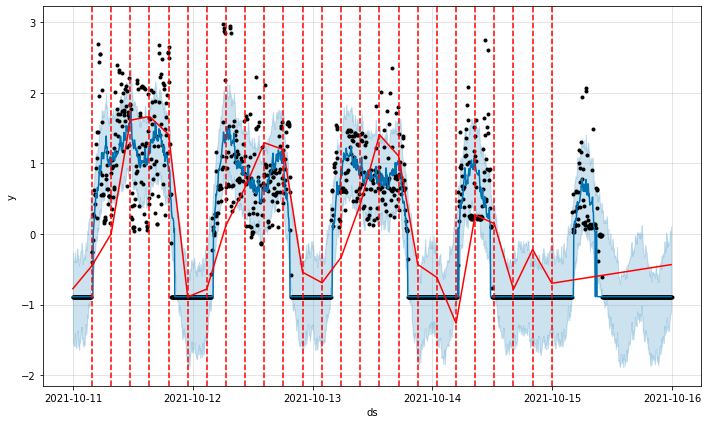

In [181]:
a = add_changepoints_to_plot(fig.gca(), model, predictions)
fig

### Hyperparameter Tuning

- Time series CV to measure forecast error using historical data
- This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point
- The forecasted values to the actual values is then compared

initial = length of training period

horizon = forecast horizon (length of time for the forecasts to be made)

cutoff = default cutoffs are made every half a horizon

period = spacing between cutoff dates

A forecast is made for every observed point between cutoff and cutoff + horizon

In [130]:
horizon = '12 hours'
cutoffs = ''

df_cv = cross_validation(
    model,
    initial='3 days',
    horizon=horizon)

INFO:prophet:Making 6 forecasts with cutoffs between 2021-10-14 05:55:00 and 2021-10-15 11:55:00
  0%|          | 0/6 [00:00<?, ?it/s]

Initial log joint probability = -87.1027
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1136.3    0.00747777       24.4806           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1143.82    0.00278913       13.0553      0.8741      0.8741      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1157.57     0.0483403       9.77527           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1170.29     0.0215631        31.128           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1172.06    0.00774158       16.0233           1           1      568   
    Iter      log prob        ||dx||      ||grad||       alpha  

 17%|█▋        | 1/6 [00:02<00:13,  2.79s/it]

Initial log joint probability = -132.185
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1209.2     0.0096922       13.7777           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1220.72     0.0548212       38.4959           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1226.81      0.142441       89.2945           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1230.31     0.0531266       20.4085           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1237.36     0.0327883       60.0558           1           1      564   
    Iter      log prob        ||dx||      ||grad||       alpha  

 33%|███▎      | 2/6 [00:05<00:09,  2.47s/it]

Initial log joint probability = -139.516
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1294.23     0.0659525       54.5346           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1312.9     0.0175358       23.1455           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1316.93     0.0538453       16.4674      0.9606      0.9606      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1318.95   0.000896598       19.4847      0.6492      0.6492      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1323.97     0.0758255       42.2312           1           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha  

 50%|█████     | 3/6 [00:07<00:07,  2.36s/it]

Initial log joint probability = -139.516
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1335.01      0.146872       163.254           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1373.97     0.0463782       72.7159           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1409.93     0.0374574       43.4857           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1415.12     0.0143325        25.553      0.2581      0.2581      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1422.06      0.604244       183.818           1           1      572   
    Iter      log prob        ||dx||      ||grad||       alpha  

 67%|██████▋   | 4/6 [00:10<00:05,  2.55s/it]

Initial log joint probability = -170.119
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1410.13     0.0153064       110.012           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1457.76     0.0805907       54.1297           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1479.78     0.0751428       29.6427           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1514.92      0.011533       21.8534           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1531.79    0.00601337       11.8686           1           1      575   
    Iter      log prob        ||dx||      ||grad||       alpha  

 83%|████████▎ | 5/6 [00:12<00:02,  2.59s/it]

Initial log joint probability = -147.242
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1471.45      0.151482       145.829           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1554.97      0.164838       221.997      0.4481           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1613.9     0.0486917       23.2099           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          1638     0.0206073       131.602           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1643.88     0.0113387        12.627           1           1      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


In [131]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-10-14 06:00:00,0.818949,0.158244,1.457877,0.684970,2021-10-14 05:55:00
1,2021-10-14 06:05:00,0.890599,0.260026,1.480469,0.629782,2021-10-14 05:55:00
2,2021-10-14 06:10:00,0.960643,0.341736,1.562819,0.490362,2021-10-14 05:55:00
3,2021-10-14 06:15:00,1.028904,0.451564,1.673235,0.269613,2021-10-14 05:55:00
4,2021-10-14 06:20:00,1.095215,0.476832,1.669636,0.385797,2021-10-14 05:55:00
...,...,...,...,...,...,...
859,2021-10-15 23:35:00,-1.322018,-6.154996,4.163589,-0.889320,2021-10-15 11:55:00
860,2021-10-15 23:40:00,-1.320279,-6.381695,4.339952,-0.889320,2021-10-15 11:55:00
861,2021-10-15 23:45:00,-1.319360,-6.241637,4.264667,-0.889320,2021-10-15 11:55:00
862,2021-10-15 23:50:00,-1.319249,-6.334201,4.592771,-0.889320,2021-10-15 11:55:00


In [132]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [133]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 01:15:00,0.585030,0.764873,0.643960,1.312468,0.579728,0.785403,0.600775
1,0 days 01:20:00,0.613317,0.783146,0.668881,1.373299,0.631203,0.808360,0.565891
2,0 days 01:25:00,0.655007,0.809325,0.696838,1.474596,0.658212,0.832375,0.538760
3,0 days 01:30:00,0.705877,0.840165,0.728803,1.643938,0.717460,0.862355,0.503876
4,0 days 01:35:00,0.760803,0.872240,0.761210,1.808568,0.751278,0.893976,0.468992
...,...,...,...,...,...,...,...,...
125,0 days 11:40:00,5.665839,2.380302,1.781328,3.866068,1.957550,1.106458,0.856589
126,0 days 11:45:00,5.594555,2.365281,1.768060,3.070350,0.566101,1.104407,0.868217
127,0 days 11:50:00,5.583447,2.362932,1.763372,2.772378,3.284125,1.102816,0.868217
128,0 days 11:55:00,5.573638,2.360855,1.759058,2.611969,0.556225,1.101675,0.868217


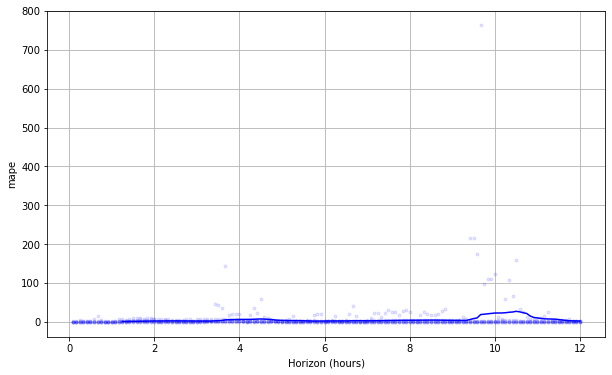

In [134]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')